## 1. Data Synthesis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Generated SVM Dataset with 0% Label Noise')

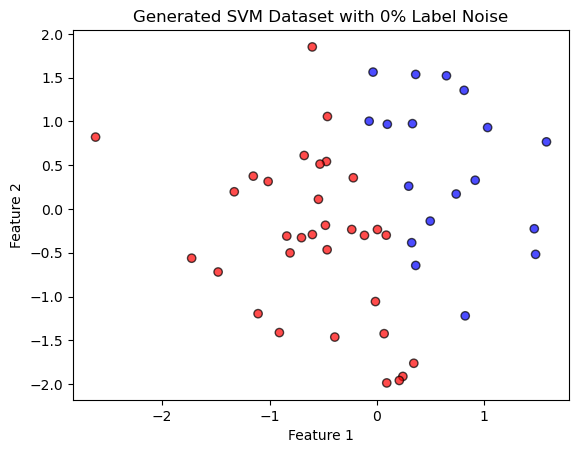

In [2]:
#Generating the dataset
np.random.seed(42)
n = 50                     # Number of samples
m = 2                      # Number of features
X = np.random.randn(n, m)  # Samples
w = np.random.randn(m)     # Random weight vector
y = np.sign(X @ w)         # Compute labels {-1, 1}

# Adding noise
noise_level = 0          # 10% of labels will be flipped
num_noisy_samples = int(noise_level * n)
noisy_indices = np.random.choice(n, num_noisy_samples, replace=False)
y_noisy = y.copy()
y_noisy[noisy_indices] *= -1  # Flip {-1, 1} labels
y = y_noisy

# Plot
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title(f"Generated SVM Dataset with {int(noise_level * 100)}% Label Noise")

## 2. Primary Solver

### Global function to compute loss

In [3]:
def computePrimalLoss(X, y, w, C):
    """
    Computes hinge loss + regularization term.

    Loss = 0.5 * ||w||² + C * sum(max(0, 1 - y_i * (w^T x_i)))

    Returns:
        float: Current loss value.
    """
    regularization = 0.5 * np.dot(w, w)
    hinge = np.maximum(0, 1 - y * np.dot(X, w))
    return regularization + C * np.sum(hinge)

### Solver (Primal)

In [4]:
import numpy as np
import time

class SVMSGDSolver:
    """
    Support Vector Machine (SVM) solver using Stochastic Gradient Descent (SGD).

    Attributes:
        C (float): Regularization parameter.
        lr (float): Learning rate for SGD updates.
        epochs (int): Number of training epochs.
        w (np.ndarray): Final optimized weight vector.
        w_history (list): List of weight vectors at each epoch.
        epoch_times (list): List of computation durations (in seconds) per epoch.
    """

    def __init__(self, C=1.0, lr=0.01, epochs=1000):
        self.C = C
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.w_history = []
        self.epoch_times = []

    def fit(self, X, y):
        """
        Trains the SVM using SGD on the provided data.

        Parameters:
            X (np.ndarray): Feature matrix of shape (n_samples, n_features).
            y (np.ndarray): Labels of shape (n_samples,) with values in {-1, 1}.

        Returns:
            self: Trained model with updated attributes.
        """
        n_samples, n_features = X.shape
        w = np.zeros(n_features)

        self.w_history = []
        self.epoch_times = []
        self.loss_history = []
        time_elapsed = 0

        for _ in range(self.epochs):
            start_time = time.perf_counter()

            # Full batch gradient descent weight update
            margin = y * np.dot(X, w)  # shape: (n_samples,)
            gradient = np.zeros_like(w)

            for i in range(n_samples):
                if margin[i] < 1:
                    gradient += -self.C * y[i] * X[i]

            # Add regularization term
            gradient += w

            # Update weights
            w = w - self.lr * gradient

            time_delta = time.perf_counter() - start_time
            time_elapsed += time_delta  # only computation measured
#             print(time_delta)

            # Record state after epoch
            self.w_history.append(w.copy())
            self.epoch_times.append(time_elapsed)

            # Compute loss (outside time tracking)
            loss = computePrimalLoss(X, y, w, self.C)
            self.loss_history.append(loss)

        self.w = w
        return self

### Train

In [5]:
# Train SVM using SGD solver
primalSolver = SVMSGDSolver(C=1.0, lr=0.01, epochs=100)
primalSolver.fit(X,y)

w_primal = primalSolver.w


# Print the optimized weight vector
print("Optimized weight vector using primal form:", w_primal)

Optimized weight vector using primal form: [-2.63150406 -0.85683102]


In [6]:
def plot_decision_boundary(X, y, w, title="SVM Decision Boundary"):
    """
    Plots the dataset and the learned decision boundary.
    
    Parameters:
        X (numpy.ndarray): Data points.
        y (numpy.ndarray): Labels {-1,1}.
        w (numpy.ndarray): Optimized weight vector.
        title (str): Title for the plot.
    """
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', alpha=0.7)

    # Compute decision boundary
    x_vals = np.linspace(-5, 5, 100)  # Set custom x-axis range

    # Decision boundary equation: w1*x1 + w2*x2 = 0  --> Solve for x2
    if w[1] != 0:  # Avoid division by zero
        y_vals = -(w[0] * x_vals) / w[1]
        plt.plot(x_vals, y_vals, 'k', label="Decision Boundary")

    # Set fixed x-axis and y-axis limits
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)  # Dynamic title
    plt.legend()
#     plt.show()

# Example usage
# plot_decision_boundary(X, y, w_primal, title="SVM Decision Boundary (Customized)")

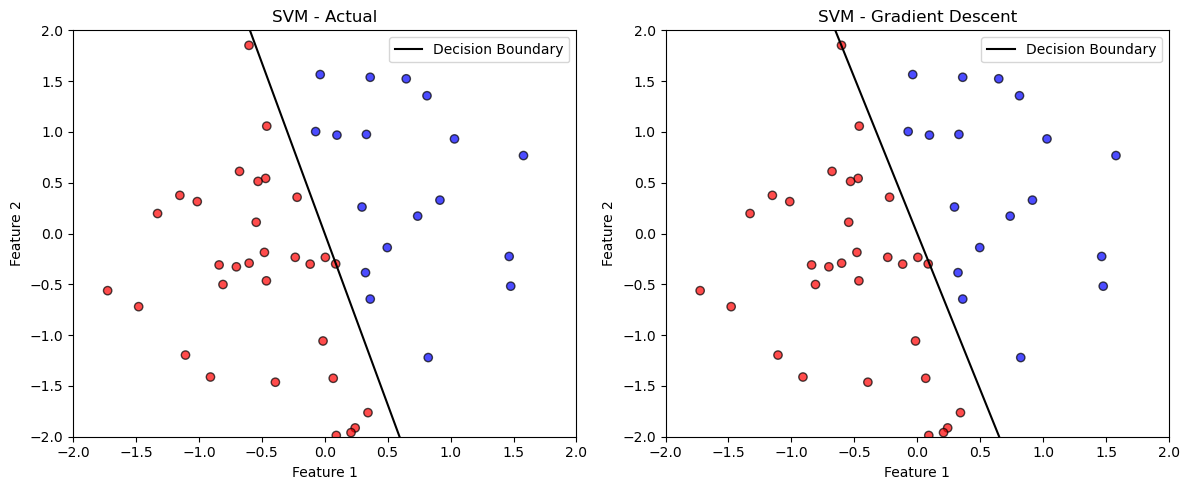

In [7]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Ensures side-by-side layout

# First subplot: Actual SVM decision boundary
plt.sca(axes[0])  # Set the first subplot as active
plot_decision_boundary(X, y, w, title="SVM - Actual")

# Second subplot: Gradient Descent SVM decision boundary
plt.sca(axes[1])  # Set the second subplot as active
plot_decision_boundary(X, y, w_primal, title="SVM - Gradient Descent")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

### 3. Dual Solver

$
\max_{\alpha_i}\sum_{i=1}^{n}\alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_i\alpha_jy_iy_j(x_i\cdot x_j)\\
\text{subject to:} 
\quad 0 \leq \alpha_i \leq C, \quad \forall i
$

### Initial Slow

In [8]:
import numpy as np

class SVMDualSolver:
    """
    Dual-form SVM solver using custom quadratic updates.
    Attributes:
        C (float): Regularization parameter.
        epochs (int): Number of optimization iterations.
        alpha (np.ndarray): Final alpha values (Lagrange multipliers).
        w (np.ndarray): Final weight vector.
        w_history (list): List of weight vectors across epochs.
        alpha_history (list): List of alpha vectors across epochs.
        epoch_times (list): List of computation durations (in seconds) per epoch.
    """

    def __init__(self, C=1.0, epochs=10):
        self.C = C
        self.epochs = epochs
        self.alpha = None
        self.w = None
        self.w_history = []
        self.alpha_history = []
        self.epoch_times = []
        self.loss_history = []


    def fit(self, X, y):
        """
        Trains the SVM in dual form on the provided data.

        Parameters:
            X (np.ndarray): Feature matrix of shape (n_samples, n_features).
            y (np.ndarray): Labels of shape (n_samples,) with values in {-1, 1}.

        Returns:
            self: Trained model with attributes updated.
        """
        n, m = X.shape

        # Initialize alpha using clipped, positive normal values
        alpha = np.random.normal(loc=self.C/2, scale=self.C/4, size=n)
        alpha = np.abs(alpha)
        alpha = np.clip(alpha, 0, self.C)
        time_elapsed = 0

        alpha = np.clip(alpha, 0, self.C)
        time_elapsed = 0

        #VECTORIZED
        # Precompute useful values outside the loop if possible
        K = X @ X.T                     # Kernel matrix (dot products)
        Y = y[:, np.newaxis] * y       # y_p * y_q outer product
#         A = alpha[:, np.newaxis] * alpha  # α_p * α_q outer product
        Q = Y * K                      # Element-wise product for the dual objective

        for epoch in range(self.epochs):
            startTime = time.perf_counter()
            # Shuffle the order of i in each epoch (excluding index 0)
            indices = np.random.permutation(np.arange(0, n))

            for i in indices:
                b = 1
                a = -0.5 * Q[i, i]

                mask = np.ones(n, dtype=bool)
                mask[i] = False

                # Vector form of:
                # b -= 0.5 * sum_over_q(α_q * y_i * y_q * K[i, q]) when p == i
                b -= 0.5 * y[i] * np.dot(alpha[mask] * y[mask], K[i, mask])

                # Same for q == i
                b -= 0.5 * y[i] * np.dot(alpha[mask] * y[mask], K[mask, i])

                # Maximize ax^2 + bx + c over [0, C]
                alpha[i] = self._maximize_quad(a, b, 0)

                
            time_elapsed += time.perf_counter() - startTime  # Just the computation duration
            w = np.sum((alpha * y)[:, np.newaxis] * X, axis=0) # weight after each epoch
            self.epoch_times.append(time_elapsed)
            self.alpha_history.append(alpha.copy())
            self.w_history.append(w)
            loss = self._compute_primal_loss(X, y, w)
            self.loss_history.append(loss)


        self.alpha = alpha
        self.w = self.w_history[-1]
        return self

    def _maximize_quad(self, a, b, c):
        """Maximizes the quadratic function ax^2 + bx + c over [0, C]."""
        if np.abs(a) < 1e-8:
            x_temp = self.C if b > 0 else 0
        else:
            x_temp = -b / (2 * a)

        x_temp = np.clip(x_temp, 0, self.C)
        f_0 = c
        f_C = a * self.C**2 + b * self.C + c
        f_x = a * x_temp**2 + b * x_temp + c

        return [0, self.C, x_temp][np.argmax([f_0, f_C, f_x])]
    
    def _compute_primal_loss(self, X, y, w):
        """
        Computes the primal SVM loss:
        Loss = 0.5 * ||w||² + C * sum(max(0, 1 - y_i * (w^T x_i)))

        Returns:
            float: Primal loss at current epoch
        """
        regularization = 0.5 * np.dot(w, w)
        hinge = np.maximum(0, 1 - y * np.dot(X, w))
        return regularization + self.C * np.sum(hinge)


#     def _compute_w(self, X, y, alpha):
#         """Computes the primal weight vector w from alpha."""
#         return np.sum((alpha * y)[:, np.newaxis] * X, axis=0)


### Updated Faster

In [9]:
import numpy as np
import time

class SVMDualSolverFast:
    """
    Optimized Dual-form SVM solver using coordinate ascent with gradient caching.
    
    Attributes:
        C (float): Regularization parameter.
        epochs (int): Number of optimization passes.
        alpha (np.ndarray): Final alpha values (Lagrange multipliers).
        w (np.ndarray): Final weight vector.
        w_history (list): List of weight vectors over epochs.
        alpha_history (list): List of alpha vectors over epochs.
        epoch_times (list): Computation duration per epoch.
        loss_history (list): Primal loss per epoch.
    """

    def __init__(self, C=1.0, epochs=10):
        self.C = C
        self.epochs = epochs
        self.alpha = None
        self.w = None
        self.w_history = []
        self.alpha_history = []
        self.epoch_times = []
        self.loss_history = []

    def fit(self, X, y):
        n, m = X.shape
        alpha = np.random.uniform(0, self.C, size=n)

        K = X @ X.T
        Q = (y[:, None] * y[None, :]) * K
        gradient = 1 - Q @ alpha

        time_elapsed = 0

        for epoch in range(self.epochs):
            start = time.perf_counter()
            for i in np.random.permutation(n):
                a = -0.5 * Q[i, i]
                b = gradient[i] + Q[i, i] * alpha[i]

                new_alpha = self._maximizeQuad(a, b)
                delta = new_alpha - alpha[i]
                alpha[i] = new_alpha

                gradient -= delta * Q[:, i]  # Update gradient using correct sign

            time_elapsed += time.perf_counter() - start
            w = np.sum((alpha * y)[:, np.newaxis] * X, axis=0)
            loss = computePrimalLoss(X, y, w, self.C)

            self.alpha_history.append(alpha.copy())
            self.w_history.append(w)
            self.loss_history.append(loss)
            self.epoch_times.append(time_elapsed)

        self.alpha = alpha
        self.w = self.w_history[-1]
        return self

    def _maximizeQuad(self, a, b):
        """Solves max for a x² + b x over [0, C]"""
        if abs(a) < 1e-12:
            x_star = self.C if b > 0 else lb
        else:
            x_star = -b / (2 * a)
        return np.clip(x_star, 0, self.C)

### Train

In [10]:
dualSolver = SVMDualSolverFast(C=1.0, epochs=15)
dualSolver.fit(X,y)

w_dual = dualSolver.w

### Point statistics

In [11]:
alpha = dualSolver.alpha
C = dualSolver.C

In [12]:
print("Total points:", len(alpha))
print("On margin (0 < alpha < C):", np.sum((alpha > 1e-5) & (alpha < C)))
print("Violating (alpha == C):", np.sum(np.isclose(alpha, C)))
print("Non-SVs (alpha ≈ 0):", np.sum(alpha < 1e-5))


Total points: 50
On margin (0 < alpha < C): 6
Violating (alpha == C): 12
Non-SVs (alpha ≈ 0): 32


### Plot the decision boundary

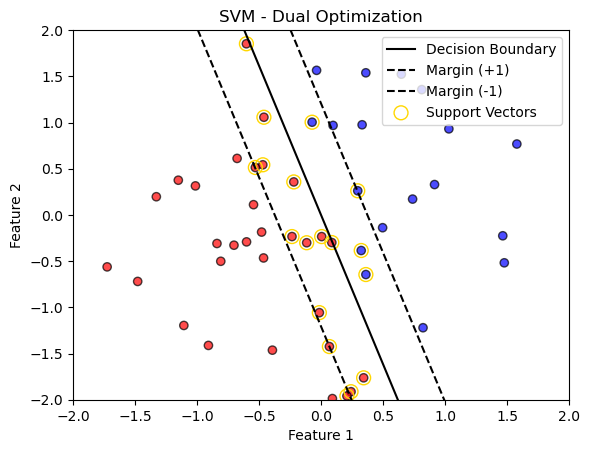

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_svm_dual(X, y, alpha, w):
    # Find vectors (where 0 < alpha < C)
    support_vector_indices = np.where((alpha > 0) )[0]
    support_vectors = X[support_vector_indices]
    
    # Calculate w^T x for each point
#     margins = y * (X @ w)
#     # Numerical tolerance for equality (not exact 1 due to float imprecision)
#     tolerance = 1e-1
#     margin_indices = np.where(np.abs(margins - 1) < tolerance)[0]
#     support_vectors = X[margin_indices]

#     # Compute bias term b using first support vector
#     b = np.mean(y[support_vector_indices] - np.dot(support_vectors, w))
#     b=0
#     print(b)

    # Define x-axis range for plotting
    x_min, x_max = np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1
    x_vals = np.linspace(x_min, x_max, 100)

    # Compute decision boundary: w0 * x1 + w1 * x2 = 0
    # => x2 = (-w0 * x1) / w1
    if w[1] != 0:  # Avoid division by zero
        y_vals = (-w[0] * x_vals) / w[1]

        # Compute margins: (decision boundary ± 1)
        margin_up = (-w[0] * x_vals - 1) / w[1]
        margin_down = (-w[0] * x_vals + 1) / w[1]

        # Plot data points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', alpha=0.7)

        # Plot decision boundary
        plt.plot(x_vals, y_vals, 'k-', label="Decision Boundary")

        # Plot margin lines
        plt.plot(x_vals, margin_up, 'k--', label="Margin (+1)")
        plt.plot(x_vals, margin_down, 'k--', label="Margin (-1)")

        # Highlight support vectors
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, edgecolors='gold', facecolors='none', label="Support Vectors")
        
        # Set fixed x-axis and y-axis limits
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        
        # Labels and legend
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.title("SVM - Dual Optimization")
        plt.legend()
#         plt.grid()
#         plt.show()
    else:
        print("w[1] is zero, cannot plot decision boundary.")

# Example usage (assumes you have computed alpha and w)
plot_svm_dual(X, y, alpha, w_dual)

## 4. cvxopt

### Solver

In [14]:
import numpy as np
from cvxopt import matrix, solvers

def train_svm_dual_cvxopt(X, y, C=1.0):
    n_samples, n_features = X.shape

    # Compute the Gram matrix
    K = np.dot(X, X.T)
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))

    G_std = np.diag(-np.ones(n_samples))
    h_std = np.zeros(n_samples)

    G_slack = np.diag(np.ones(n_samples))
    h_slack = np.ones(n_samples) * C

    G = matrix(np.vstack((G_std, G_slack)))
    h = matrix(np.hstack((h_std, h_slack)))

    A = matrix(y.astype(float), (1, n_samples))
    b = matrix(0.0)

    # Disable solver output
    solvers.options['show_progress'] = False

    # Solve QP problem
    solution = solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(solution['x'])

    return alpha

def compute_w(X, y, alpha):
    return np.sum((alpha * y)[:, np.newaxis] * X, axis=0)

### Train

In [15]:
startTime = time.perf_counter()
alpha_cvx = train_svm_dual_cvxopt(X, y, C=1.0)
time_cvx = time.perf_counter() - startTime
w_cvx = compute_w(X, y, alpha_cvx)
print("Time by cvx opt = ", time_cvx)

Time by cvx opt =  0.01988409999466967


In [16]:
loss_cvx =  computePrimalLoss(X,y,w_cvx,1)

In [17]:
np.sum(dualSolver.epoch_times)

0.07822720007970929

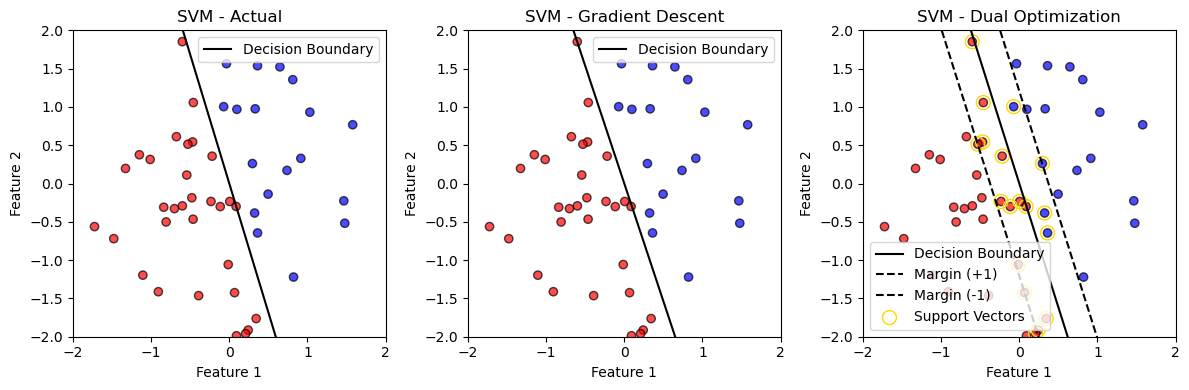

In [18]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Ensures side-by-side layout

# First subplot: Actual SVM decision boundary
plt.sca(axes[0])  # Set the first subplot as active
plot_decision_boundary(X, y, w, title="SVM - Actual")

# Second subplot: Gradient Descent SVM decision boundary
plt.sca(axes[1])  # Set the second subplot as active
plot_decision_boundary(X, y, w_primal, title="SVM - Gradient Descent")


# Third subplot: Gradient Descent SVM decision boundary
plt.sca(axes[2])  # Set the second subplot as active
plot_svm_dual(X, y, alpha, w_dual)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

## Time comparision

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_history(model_sgd, model_dual):
    # ---- SGD ----
    loss_sgd = model_sgd.loss_history
    epoch_times_sgd = model_sgd.epoch_times

    # ---- Dual ----
    loss_dual = model_dual.loss_history
    epoch_times_dual = model_dual.epoch_times
    
    # Simulate each epoch as equal time unit if not measured (e.g., 1 sec per epoch)
#     if hasattr(model_dual, 'epoch_times') and model_dual.epoch_times:
#         epoch_times_dual = np.cumsum(model_dual.epoch_times)
#     else:
#         epoch_times_dual = np.arange(1, len(w_norms_dual)+1)  # fallback: 1 unit per epoch

    # ---- Plot ----
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_times_sgd, loss_sgd, label='SGD Solver', marker='x')
    plt.plot(epoch_times_dual, loss_dual, label='Dual Solver', marker='x')
    plt.axhline(y=loss_cvx, color='green', label='CVX Final Loss')
    plt.yscale("log")

    plt.xlabel('Cumulative Epoch Time (s)')
    plt.ylabel('Primal Loss')
    plt.title('Loss vs Epoch Time for SGD and Dual SVM Solvers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


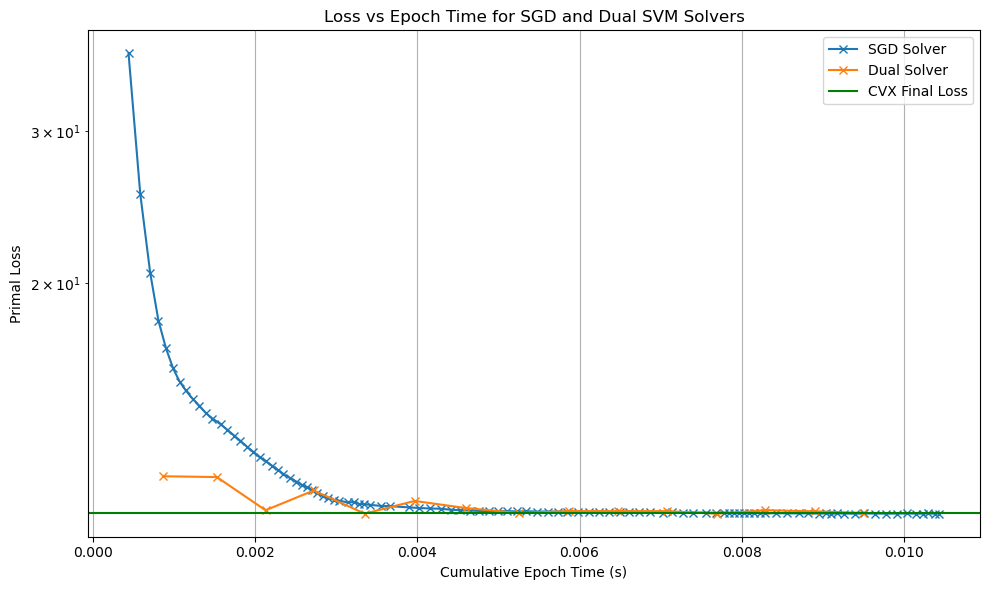

In [39]:
plot_loss_history(primalSolver,dualSolver)

In [21]:
loss_primal = primalSolver.loss_history[-1]
loss_dual = dualSolver.loss_history[-1]

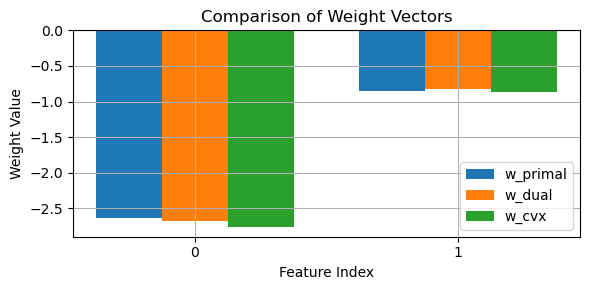

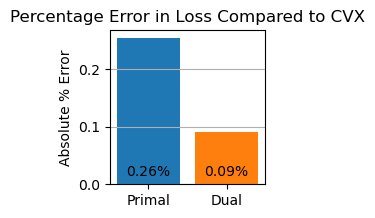

In [22]:
# Flatten weight vectors for plotting
w_primal = w_primal.flatten()
w_dual = w_dual.flatten()
w_cvx = w_cvx.flatten()

# Define consistent colors
colors = {
    'primal': 'tab:blue',
    'dual': 'tab:orange',
    'cvx': 'tab:green'
}

n_features = len(w_primal)
x = np.arange(n_features)
bar_width = 0.25

# Plot 1: Comparison of w vectors
plt.figure(figsize=(6, 3))

plt.bar(x - bar_width, w_primal, width=bar_width, label='w_primal', color=colors['primal'])
plt.bar(x, w_dual, width=bar_width, label='w_dual', color=colors['dual'])
plt.bar(x + bar_width, w_cvx, width=bar_width, label='w_cvx', color=colors['cvx'])

plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Comparison of Weight Vectors')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Comparison of Losses
# Compute percentage absolute errors relative to CVX loss
primal_error_pct = abs((loss_primal - loss_cvx) / loss_cvx) * 100
dual_error_pct = abs((loss_dual - loss_cvx) / loss_cvx) * 100

# Labels and data
methods = ['Primal', 'Dual']
errors = [primal_error_pct, dual_error_pct]
colors = ['tab:blue', 'tab:orange']  # Consistent with previous plots

# Plotting
plt.figure(figsize=(2, 2))
bars = plt.bar(methods, errors, color=colors)

# Annotate the bars with actual values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,  0.01, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Absolute % Error')
plt.title('Percentage Error in Loss Compared to CVX')
plt.grid(axis='y')
# plt.tight_layout()
plt.show()

$$h(x) = \operatorname{sign}(w^\top x)$$